#Introduction

A data consulting/ analytics company has asked us to develop a model to predict why high performing employees are leaving at a higher rate. This notebook will process the data given and the markdowns will explain what is happening and what insights can be drawn here.

#Data

##Imports

This section is simply used to import the libraries necessary to determine the model of the problem. As well as importing the dataset that Bob has provided us with.

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [0]:
hr_data=pd.read_csv('/content/Drive/My Drive/hr-data.csv',low_memory=False)

##Exploratory Data Analysis

Now that the data has been imported into the notebook, we will now be performing exploratory data analysis on it.

In [4]:
hr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14999 non-null  int64  
 1   satisfaction_level     14999 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   churn                  14999 non-null  int64  
 8   promotion_last_5years  14999 non-null  int64  
 9   sales                  14999 non-null  object 
 10  salary                 14999 non-null  object 
dtypes: float64(2), int64(7), object(2)
memory usage: 1.3+ MB


In [5]:
hr_data.shape

(14999, 11)

The dataset contains 11 columns of variables listed above and has 14999 entries. The satisfaction_level and last_evaluation is a float variable, whereas sales and salary are object types. Everything else is integer type.

In [6]:
#sample of what the data looks like
hr_data

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years,sales,salary
0,0,0.38,0.53,2,157,3,0,1,0,sales,low
1,1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,3,0.72,0.87,5,223,5,0,1,0,sales,low
4,4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...,...
14994,14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,14997,0.11,0.96,6,280,4,0,1,0,support,low


In [7]:
hr_data.isnull().sum()

id                       0
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
churn                    0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [8]:
hr_data.nunique()

id                       14999
satisfaction_level          92
last_evaluation             65
number_project               6
average_montly_hours       215
time_spend_company           8
Work_accident                2
churn                        2
promotion_last_5years        2
sales                       10
salary                       3
dtype: int64

In [0]:
#types of variables
categorical_variables = [
    'number_project',
    'time_spend_company',
    'Work_accident',
    'promotion_last_5years'
    'sales'
    'salary'
]

numerical_variables = [
    'satisfaction_level',
    'last_evaluation',
    'average_montly_hours'
]

target = ['churn']

There are no null values in the dataset. The columns has been sorted according to their variable types. Categorical and numerical data. The target data is the churn column for employees if the employee has left.

In [10]:
hr_data_dm=pd.get_dummies(hr_data, columns=['sales','salary'])
hr_data_dm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14999 non-null  int64  
 1   satisfaction_level     14999 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   churn                  14999 non-null  int64  
 8   promotion_last_5years  14999 non-null  int64  
 9   sales_IT               14999 non-null  uint8  
 10  sales_RandD            14999 non-null  uint8  
 11  sales_accounting       14999 non-null  uint8  
 12  sales_hr               14999 non-null  uint8  
 13  sales_management       14999 non-null  uint8  
 14  sales_marketing        14999 non-null  uint8  
 15  sa

Create a new dataframe for dummy variables to be applied for sales and salary column.

In [11]:
#descriptive statistics of following columns
hr_data[['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company']].describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233
std,0.248631,0.171169,1.232592,49.943099,1.460136
min,0.090000,0.360000,2.000000,96.000000,2.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000


In [12]:
hr_data['churn'].value_counts()

0    11428
1     3571
Name: churn, dtype: int64

In [13]:
hr_data['churn'].value_counts(normalize=True)

0    0.761917
1    0.238083
Name: churn, dtype: float64

The percentage in people churning from the Company is 23.8% with 3571. Whereas the ones who stayed are 76.2% with 11428. 

In [14]:
hr_data.groupby('churn').mean()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
churn,,,,,,,,
0,7811.340742,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,6499.439653,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


We grouped the data by churn and averaged the data and here are my observations:

- The average satisfaction level of the employees of the ones who did not churn are higher than the ones who did. 
- The number of times employees have been promoted in the last 5 years are higher than the ones who did. 
- The mean of average monthly hours are shorter for the ones who stayed compared to the ones who left but not by a lot.
- There are more work accidents for the ones who stayed.
- The average of last evaluation, number project and time spend company are very close to each other.

In [15]:
hr_data.groupby('sales').mean()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
sales,,,,,,,,,
IT,7655.845966,0.618142,0.716830,3.816626,202.215974,3.468623,0.133659,0.222494,0.002445
RandD,6777.346887,0.619822,0.712122,3.853875,200.800508,3.367217,0.170267,0.153748,0.034307
accounting,7255.035202,0.582151,0.717718,3.825293,201.162973,3.522816,0.125163,0.265971,0.018253
hr,7035.889039,0.598809,0.708850,3.654939,198.684709,3.355886,0.120433,0.290934,0.020298
management,9438.363492,0.621349,0.724000,3.860317,201.249206,4.303175,0.163492,0.144444,0.109524
marketing,7750.684149,0.618601,0.715886,3.687646,199.385781,3.569930,0.160839,0.236597,0.050117
product_mng,8095.417960,0.619634,0.714756,3.807095,199.965632,3.475610,0.146341,0.219512,0.000000
sales,7675.873430,0.614447,0.709717,3.776329,200.911353,3.534058,0.141787,0.244928,0.024155
support,7211.809780,0.618300,0.723109,3.803948,200.758188,3.393001,0.154778,0.248991,0.008973


In [16]:
hr_data.groupby('salary').mean()

,id,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,churn,promotion_last_5years
salary,,,,,,,,,
high,8621.897332,0.637470,0.704325,3.767179,199.867421,3.692805,0.155214,0.066289,0.058205
low,7326.897622,0.600753,0.717017,3.799891,200.996583,3.438218,0.142154,0.296884,0.009021
medium,7478.844400,0.621817,0.717322,3.813528,201.338349,3.529010,0.145361,0.204313,0.028079


We also calulated categroical means for other sales and salary to get ma more detailed sense of our data.
- satisfaction_levels, last_evaluation, average_monthly_hours are very close to each other.
- promotion_last_5years data varies in different groupings.

###Data visualization

Here is a data visualization of the data. Every column that involves a 0 and 1 as its values means no and yes respectively.

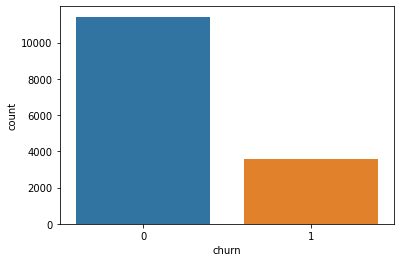

In [17]:
#bar plot of the churn count.
sb.countplot(x='churn',data=hr_data)
plt.show()

In [0]:
#function for bar plots of churn frequency for the categorical data 
def bar_graph(column):
  pd.crosstab(hr_data[column], hr_data['churn']).plot(kind='bar')
  plt.title('Churn type frequency for '+column)
  plt.xlabel(column)
  plt.ylabel('Fequency of Churns')
  return

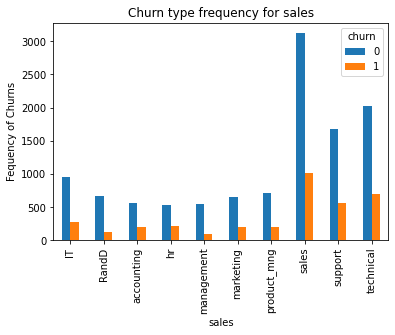

In [19]:
bar_graph('sales')

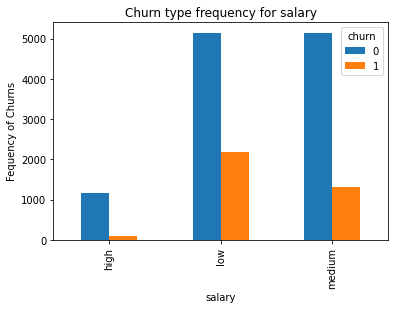

In [20]:
bar_graph('salary')

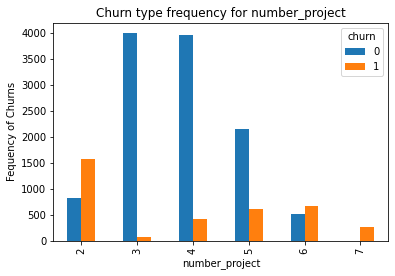

In [21]:
bar_graph('number_project')

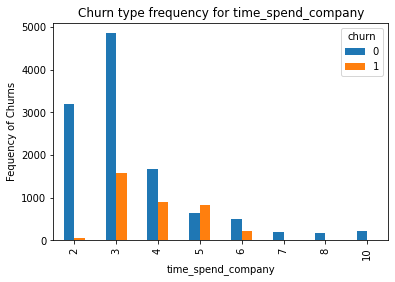

In [22]:
#time spent at the company by years
bar_graph('time_spend_company')

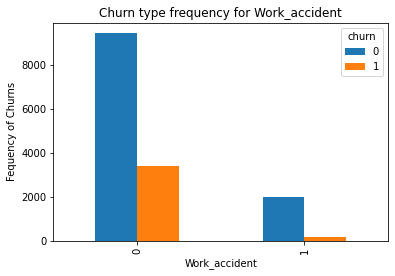

In [23]:
bar_graph('Work_accident')

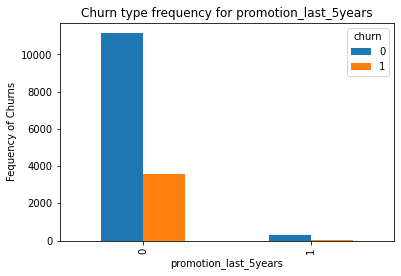

In [24]:
bar_graph('promotion_last_5years')

In all the bar charts above, the only time the yes churn exceeds the no is number_project 2. Raises question as to what's happening there.

In [0]:
#function for distribution plots for the numerical data and 3 box and whiskers plot of the column.
# The first box and whiskers plot represents all of the satisfaction_level
# The other 2 boxes are filtered by the churn type
def continous_graph(column):
  fig, axs = plt.subplots(2,2,figsize=(10,10))
  sb.distplot(hr_data.loc[hr_data['churn']==0,column],bins=10, label='0', ax=axs[0][0])
  sb.distplot(hr_data.loc[hr_data['churn']==1,column],bins=10, label='1',ax=axs[0][0])
  sb.boxplot(x=column, data=hr_data,ax=axs[0][1])
  sb.boxplot(x=column, data=hr_data.loc[hr_data['churn']==1, :],ax=axs[1][0])
  sb.boxplot(x=column, data=hr_data.loc[hr_data['churn']==0, :],ax=axs[1][1])
  return

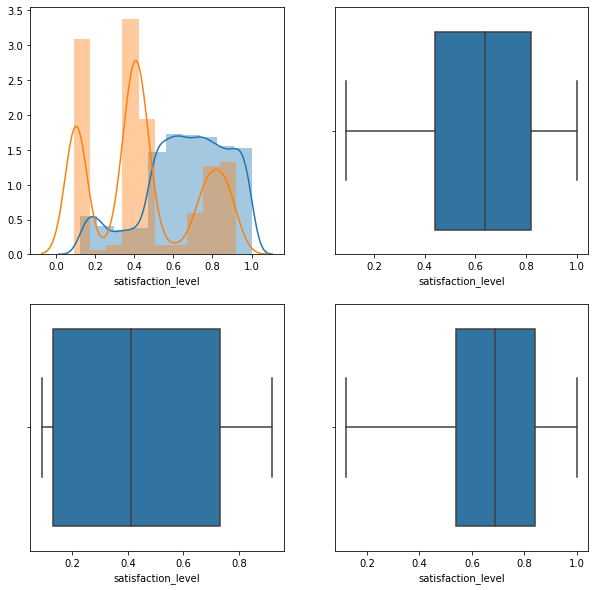

In [26]:
continous_graph('satisfaction_level')

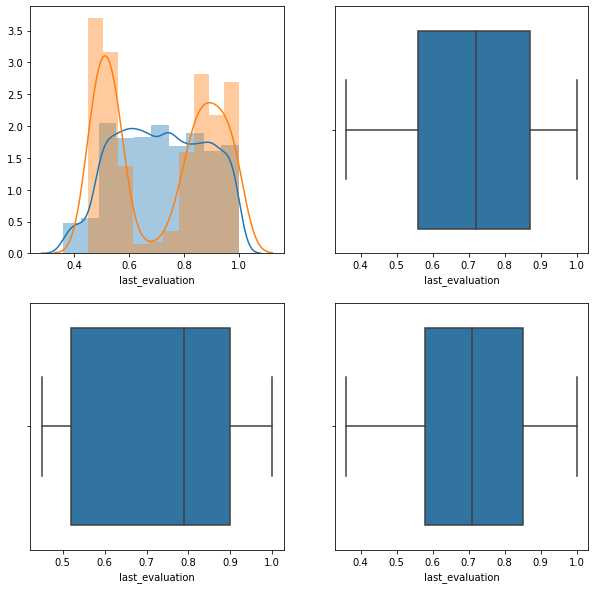

In [27]:
continous_graph('last_evaluation')

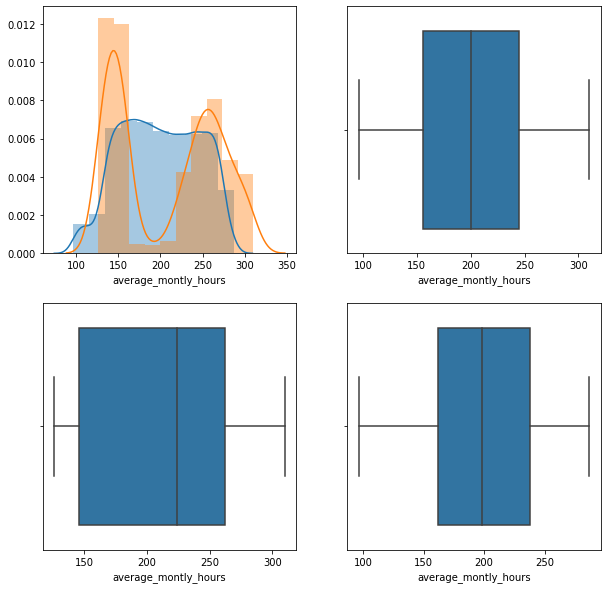

In [28]:
continous_graph('average_montly_hours')

In the multiple graphs of the continous data above, we can see that the ones who churns are more in the lower end of the graph where as the ones who stays are in the higher end of the respective spectrum. The interesting thing about these representation is that even though the some of the means calculated earlier grouped by churn, the ones who ones who left are split on both ends where as the ones who stayed are moreso groupbed together.

##Modeling

Here we start modeling by taking the dataset with the created dummy variables and we perform features selection by splitting data into train and test size, 80% and 20%, scale the data, fit it into the Logistic Regression and look at the coefficient.

In [29]:
hr_data_dm.columns

Index(['id', 'satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'churn',
       'promotion_last_5years', 'sales_IT', 'sales_RandD', 'sales_accounting',
       'sales_hr', 'sales_management', 'sales_marketing', 'sales_product_mng',
       'sales_sales', 'sales_support', 'sales_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')

In [0]:
x_variables=['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'sales_IT', 'sales_RandD', 'sales_accounting',
       'sales_hr', 'sales_management', 'sales_marketing', 'sales_product_mng',
       'sales_sales', 'sales_support', 'sales_technical', 'salary_high',
       'salary_low', 'salary_medium']

In [0]:
x = hr_data_dm[x_variables]
y = hr_data_dm['churn']

In [0]:
#feature selection
logreg=LogisticRegression(penalty='none',solver='lbfgs',verbose=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [33]:
x_train.shape

(11999, 20)

In [34]:
logreg.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [0]:
x_train_scaler=StandardScaler()

#fit scaler
x_train_scaler.fit(x_train)

#transform the data
x_train_scaled = x_train_scaler.transform(x_train)

In [36]:
logreg.fit(x_train_scaled,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [37]:
coef=logreg.coef_
coef

array([[-1.04201863,  0.11407237, -0.38544566,  0.25025097,  0.39304588,
        -0.53431387, -0.20692624, -0.02904122, -0.14010618,  0.01122554,
         0.06904565, -0.07918959,  0.02121624, -0.00450201,  0.00824295,
         0.02786085,  0.05296531, -0.41920111,  0.24135083, -0.01133905]])

In [38]:
x_train.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'sales_IT', 'sales_RandD', 'sales_accounting',
       'sales_hr', 'sales_management', 'sales_marketing', 'sales_product_mng',
       'sales_sales', 'sales_support', 'sales_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')

We'll use any coefficients greater than 0.10 on both negative and positive. So that leaves us with the following variables
- satisfaction_level
- last_evaluation
- number_project
- average_monthly_hours
- time_spend_company
- work_accident
- promotion_last_5years
- sales_RandD
- salary_high
- salary_low.

We go back plugging the data only this time with the ones the listed variables above and the different type of Logistic Regression.

In [0]:
x_variables_feature=['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'sales_RandD', 'salary_high',
       'salary_low']

In [0]:
x2=hr_data_dm[x_variables_feature]
y2=hr_data_dm['churn']

In [0]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

In [0]:
x2_train_scaler=StandardScaler()

#fit scaler
x2_train_scaler.fit(x2_train)

#transform the data
x2_train_scaled = x2_train_scaler.transform(x2_train)

In [0]:
# No Penalty
logreg2 = LogisticRegression(penalty='none',solver='lbfgs',verbose=1)

In [44]:
logreg2.fit(x2_train, y2_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [45]:
y2_pred = logreg2.predict(x2_test)
logreg2.score(x2_test, y2_test)

0.7856666666666666

In [46]:
logreg2.classes_

array([0, 1])

In [47]:
logreg2.predict_proba(x2_train)

array([[0.90912836, 0.09087164],
       [0.68806533, 0.31193467],
       [0.95814735, 0.04185265],
       ...,
       [0.89412331, 0.10587669],
       [0.75223744, 0.24776256],
       [0.83454597, 0.16545403]])

In [48]:
print(classification_report(y_test, y2_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2294
           1       0.58      0.34      0.42       706

    accuracy                           0.79      3000
   macro avg       0.70      0.63      0.65      3000
weighted avg       0.76      0.79      0.76      3000



In [49]:
confusion_matrix(y2_test,y2_pred)

array([[2120,  174],
       [ 469,  237]])

In [0]:
logreg3 = LogisticRegression(penalty='l1',solver='saga',verbose=1)
logreg4 = LogisticRegression(penalty='l2',solver='lbfgs',verbose=1)
logreg5 = LogisticRegression(penalty='elasticnet',class_weight='balanced',solver='saga',verbose=1)

In [51]:
#Logistic Regression with L1 Penalty
logreg3.fit(x2_train, y2_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=1,
                   warm_start=False)

In [52]:
logreg3.score(x2_test, y2_test)

0.7606666666666667

In [53]:
logreg3.predict_proba(x2_train)

array([[0.75515919, 0.24484081],
       [0.69612505, 0.30387495],
       [0.83601629, 0.16398371],
       ...,
       [0.83415278, 0.16584722],
       [0.72255835, 0.27744165],
       [0.73052198, 0.26947802]])

In [0]:
y3_pred = logreg3.predict(x2_test)

In [55]:
print(classification_report(y2_test, y3_pred))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      2294
           1       0.00      0.00      0.00       706

    accuracy                           0.76      3000
   macro avg       0.38      0.50      0.43      3000
weighted avg       0.58      0.76      0.66      3000



In [56]:
#Logistic Regression with L2 Penalty
logreg4.fit(x2_train, y2_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [57]:
logreg4.score(x2_test, y2_test)

0.7826666666666666

In [58]:
logreg4.predict_proba(x2_train)

array([[0.90938584, 0.09061416],
       [0.68725001, 0.31274999],
       [0.95759759, 0.04240241],
       ...,
       [0.89474049, 0.10525951],
       [0.75001119, 0.24998881],
       [0.83352128, 0.16647872]])

In [0]:
y4_pred = logreg4.predict(x2_test)

In [60]:
print(classification_report(y2_test, y4_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2294
           1       0.57      0.32      0.41       706

    accuracy                           0.78      3000
   macro avg       0.69      0.62      0.64      3000
weighted avg       0.76      0.78      0.76      3000



In [61]:
#Logist Regrssion with elasticnet penalty but error kept occuring.
logreg5.fit(x2_train, y2_train)

ValueError: ignored

#Conclusions

After running the different types of regression models, with different types of penalty and solver, we can say that we can predict accurately around 78% percent accurately whether the employee will churn or not. The Variables that influence it are the following 
- satisfaction_level
- last_evaluation
- number_project
- average_monthly_hours
- time_spend_company
- work_accident
- promotion_last_5years
- sales_RandD
- salary_high
- salary_low.

The thing missing about this is the external factors that affect the employees decision. In the graph with the satisfactory, there are some who are pretty satisfied but left the company. 